In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import os
import seaborn as sns
import time

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.ndimage.measurements import label

%matplotlib inline

### Dataset Preparation

In [2]:
vehicle_images = np.array(glob.glob('vehicles/**/*.png'))
non_vehicle_images = np.array(glob.glob('non-vehicles/**/*.png'))

n_vehicles = len(vehicle_images)
n_non_vehicles = len(non_vehicle_images)

print("Number of vehicles samples =", n_vehicles)
print("Number of non vehicle samples =", n_non_vehicles)

Number of vehicles samples = 8792
Number of non vehicle samples = 8968


### Exploratory visualization of the dataset

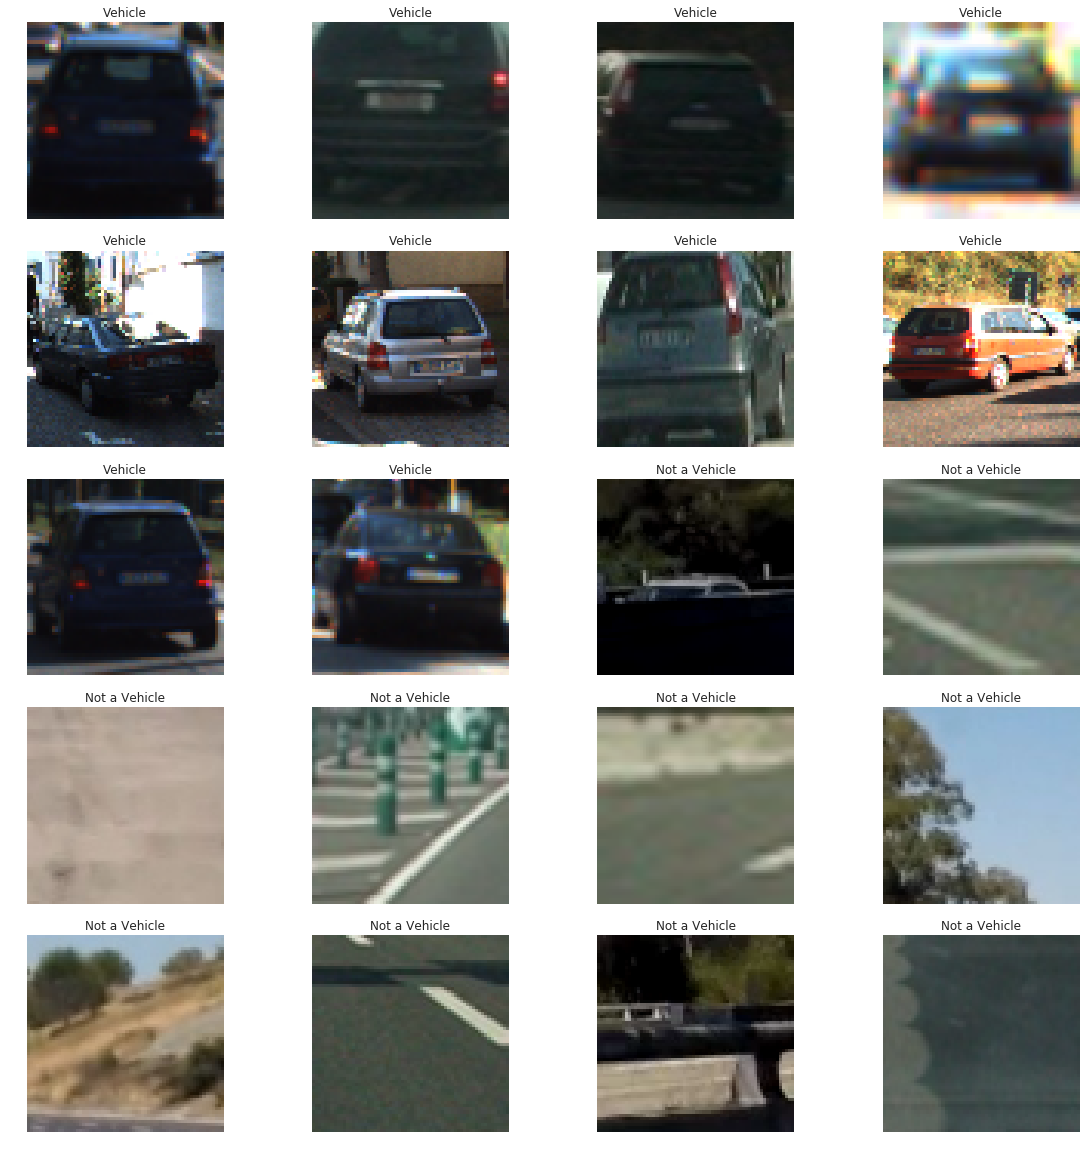

In [3]:
vehicle_idxs = np.random.randint(n_vehicles, size=10)
non_vehicle_idxs = np.random.randint(n_non_vehicles, size=10)

vehicles_samples = vehicle_images[vehicle_idxs]
non_vehicles_samples = non_vehicle_images[non_vehicle_idxs]

fig, axs = plt.subplots(5,4, figsize=(16, 16))
fig.tight_layout()
axs = axs.ravel()
i = 0

# Step through the list and search for chessboard corners
for sample in vehicles_samples:
    img = cv2.imread(sample)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Vehicle')
    axs[i].imshow(img)
    i +=1
    
for sample in non_vehicles_samples:
    img = cv2.imread(sample)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Not a Vehicle')
    axs[i].imshow(img)
    i +=1

### Spatial Binning

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

### Histogram feature extraction

In [5]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Histogram of Oriented Gradients (HOG)

(-0.5, 63.5, 63.5, -0.5)

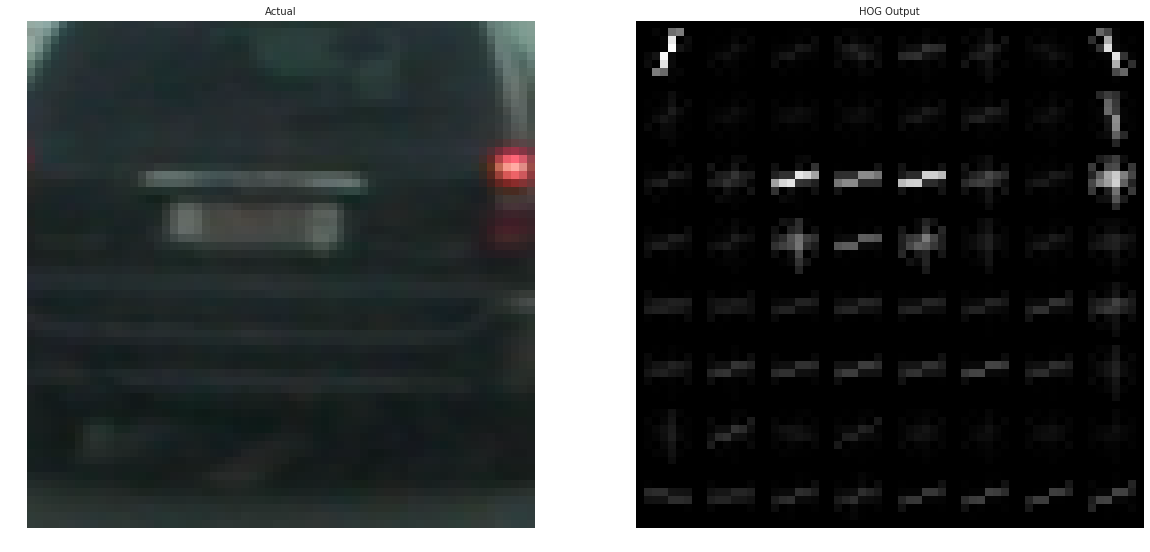

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
test_image = cv2.cvtColor(cv2.imread(np.random.choice(vehicles_samples, 1)[0]), cv2.COLOR_BGR2RGB)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.axis('off')
ax1.set_title('Actual', fontsize=10)
ax2.imshow(get_hog_features(cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY), 11, 8, 2, vis=True, feature_vec=True)[1], cmap='gray')
ax2.set_title('HOG Output', fontsize=10)
ax2.axis('off')

### Generate/Extract features vector for all the images

In [7]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True,
                     hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat is True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat is True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat is True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

c_space = 'YUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel='ALL'

vehicle_features = extract_features(vehicle_images, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
non_vehicle_features = extract_features(non_vehicle_images, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64) 
y = np.hstack((np.ones(n_vehicles), np.zeros(n_non_vehicles)))

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to normalise X
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test=train_test_split(
    scaled_X, y, test_size=0.2, stratify=y)

print('Feature vector length:', len(X_train[0]))

assert(len(X_train)==len(y_train))

Feature vector length: 8460


### Train a classifier

In [8]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

33.29 Seconds to train SVC...
Test Accuracy of SVC =  0.989
My SVC predicts:  [ 0.  1.  0.  1.  0.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  1.  0.  0.  1.  0.  0.  0.]
0.00324 Seconds to predict 10 labels with SVC


### Use classifier to detect a car in an input image

(-0.5, 1279.5, 719.5, -0.5)

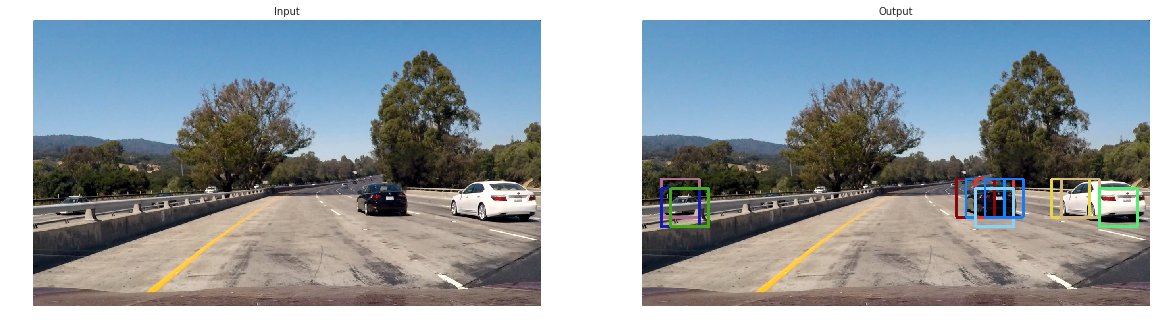

In [9]:
def convert_color(img, conv='RGB2YUV'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if len(bbox) == 2 and bbox[0] is not None and bbox[1] is not None:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)), thick)
    # Return the image copy with boxes drawn
    return imcopy

def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_size=(32, 32), hist_bins=32): 
    rects = []
    
    img = img.astype(np.float32) / 255
    img_tosearch = img[ystart:ystop, :, :]
        
    if color_space != 'RGB':
            if color_space == 'HSV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else:
        ctrans_tosearch = img_tosearch
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
        
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(hog_channel, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                    
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rects.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                
    return rects

ystart = 400
ystop = 656
scale = 1.5

test_image = cv2.cvtColor(cv2.imread('test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
rects = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
output_img = draw_boxes(test_image, rects)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.axis('off')
ax1.set_title('Input', fontsize=10)
ax2.imshow(output_img)
ax2.set_title('Output', fontsize=10)
ax2.axis('off')

### Multi-scale window sliding

In [10]:
def slide_window(img, ystart, ystop, scale):         
    img_tosearch = img[ystart:ystop, :, :]

    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Initialize a list to append window positions to
    window_list = []
    
    for ys in range(nysteps+1):
        for xs in range(nxsteps+1):
            ypos = ys*cells_per_step
            xpos = xs*cells_per_step
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Calculate window position
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)

            window_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))

    return window_list

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

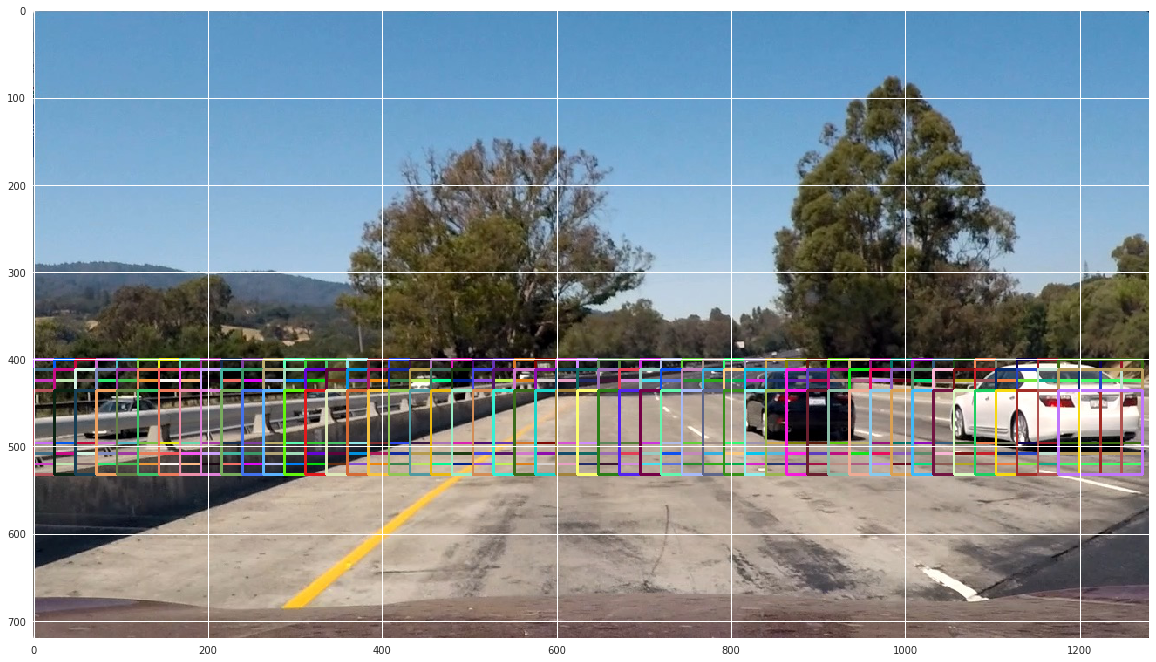

In [14]:
ystart = 400
ystop = 526
scale = 1.5

output_img = draw_boxes(test_image, slide_window(test_image, ystart, ystop, scale), thick=2)

ystart = 412
ystop = 538
scale = 1.5

output_img = draw_boxes(output_img, slide_window(test_image, ystart, ystop, scale), thick=2)

plt.figure(figsize=(20,20))
plt.imshow(output_img)

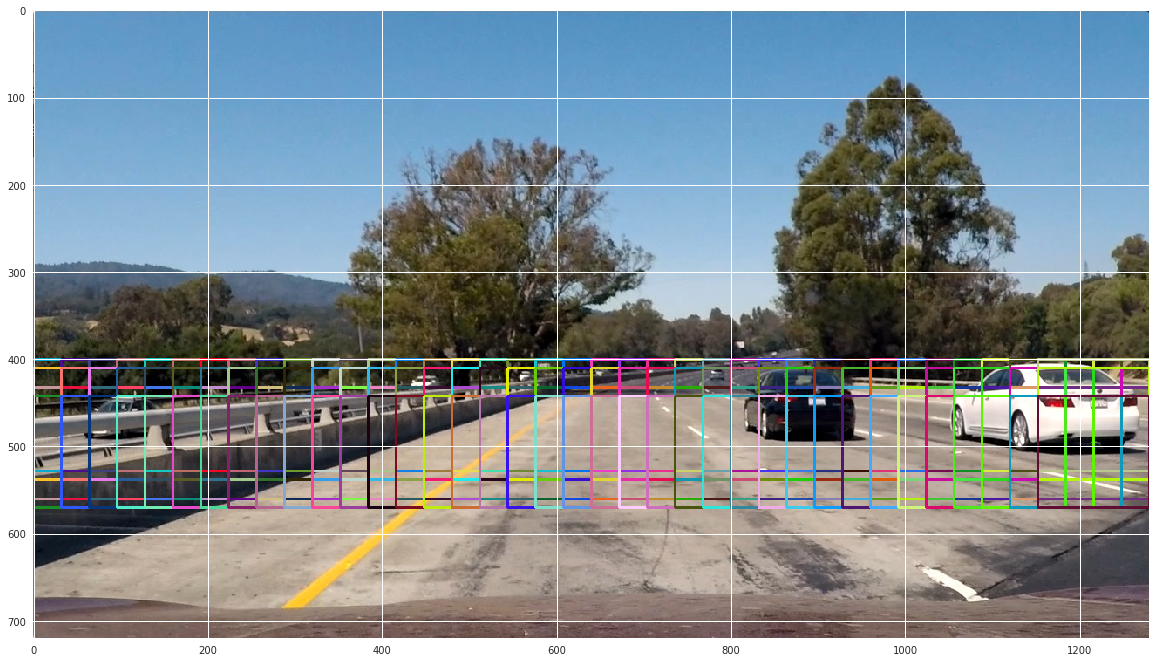

In [15]:
ystart = 400
ystop = 560
scale = 2.0

output_img = draw_boxes(test_image, slide_window(test_image, ystart, ystop, scale), thick=2)

ystart = 410
ystop = 570
scale = 2.0

output_img = draw_boxes(output_img, slide_window(test_image, ystart, ystop, scale), thick=2)

plt.figure(figsize=(20,20))
plt.imshow(output_img)

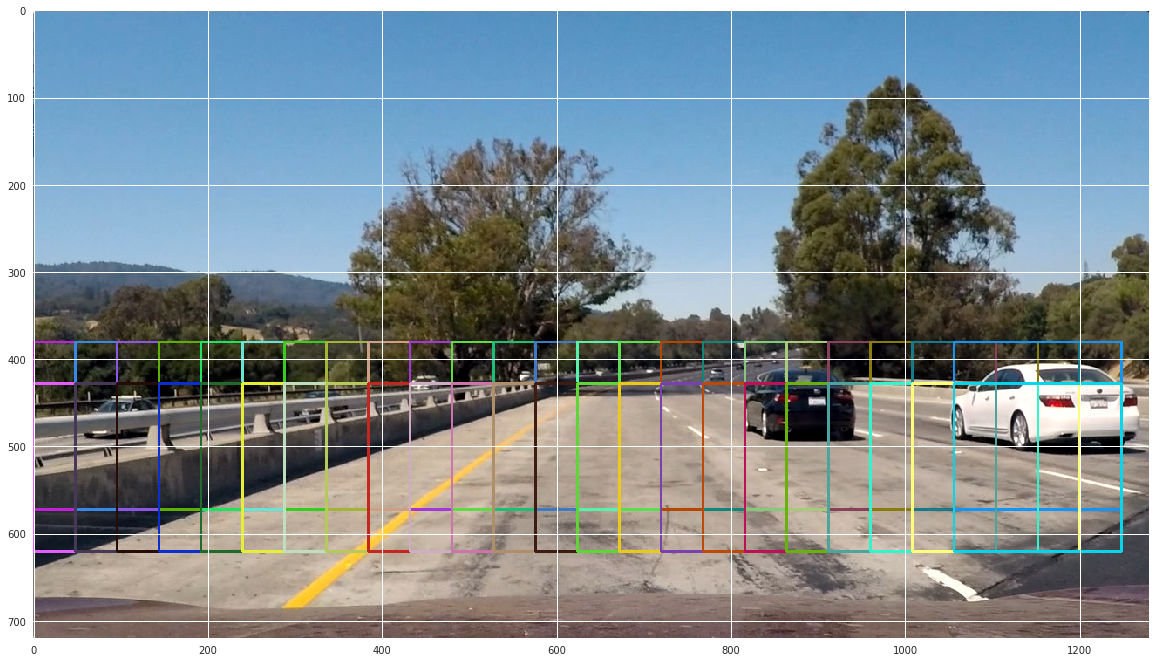

In [16]:
ystart = 380
ystop = 654
scale = 3.0

windows = slide_window(test_image, ystart, ystop, scale)
rects = search_windows(test_image, windows, svc, X_scaler)

ystart = 400
ystop = 664
scale = 3.0

windows = slide_window(test_image, ystart, ystop, scale)
rects.append(search_windows(test_image, windows, svc, X_scaler))
output_img = draw_boxes(test_image, rects, thick=2)

plt.figure(figsize=(20,20))
plt.imshow(output_img)

### Combine multi scale windows

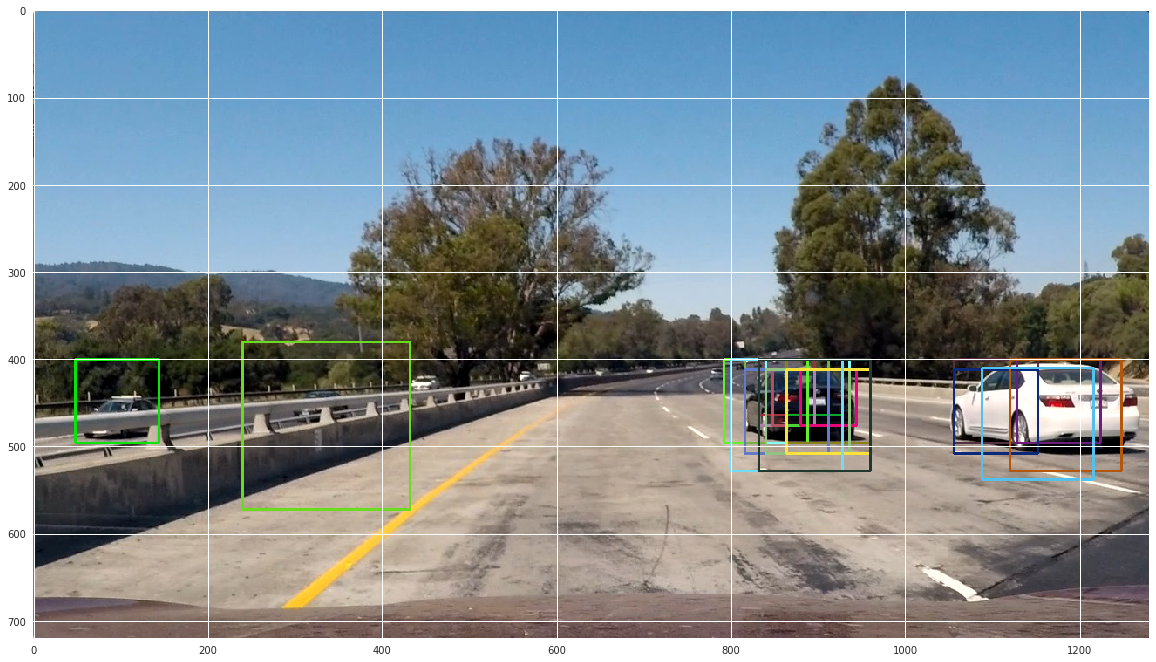

In [11]:
test_image = cv2.cvtColor(cv2.imread('test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
rectangles = []

ystart = 400
ystop = 480
scale = 1.0

rectangles.append(find_cars(test_image, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

ystart = 412
ystop = 498
scale = 1.0

rectangles.append(find_cars(test_image, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

ystart = 400
ystop = 526
scale = 1.5

rectangles.append(find_cars(test_image, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

ystart = 412
ystop = 538
scale = 1.5

rectangles.append(find_cars(test_image, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

ystart = 400
ystop = 560
scale = 2.0

rectangles.append(find_cars(test_image, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

ystart = 410
ystop = 570
scale = 2.0

rectangles.append(find_cars(test_image, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

ystart = 380
ystop = 654
scale = 3.0

rectangles.append(find_cars(test_image, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

ystart = 400
ystop = 664
scale = 3.0

rectangles.append(find_cars(test_image, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

rectangles = [item for sublist in rectangles for item in sublist]
output_img = draw_boxes(test_image, rectangles, thick=2)

plt.figure(figsize=(20,20))
plt.imshow(output_img)

### Detect/Remove false positives and duplicates

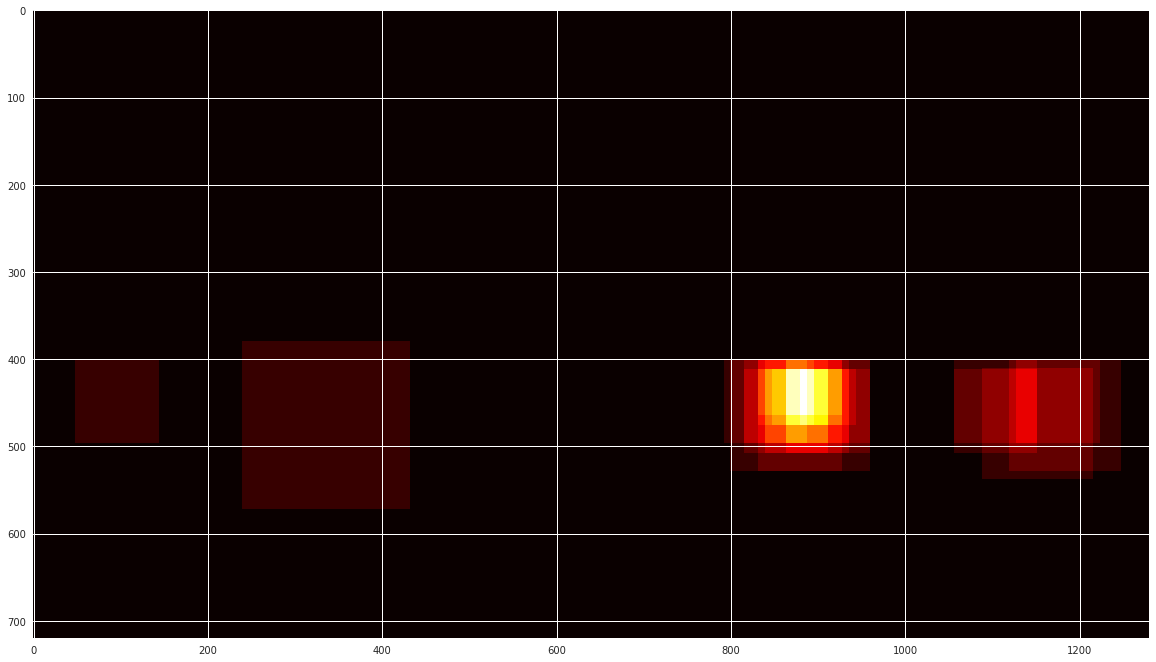

In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

heatmap_img = np.zeros_like(test_image[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)

plt.figure(figsize=(20,20))
plt.imshow(heatmap_img, cmap='hot')

### Threshold Heatmap for false positives

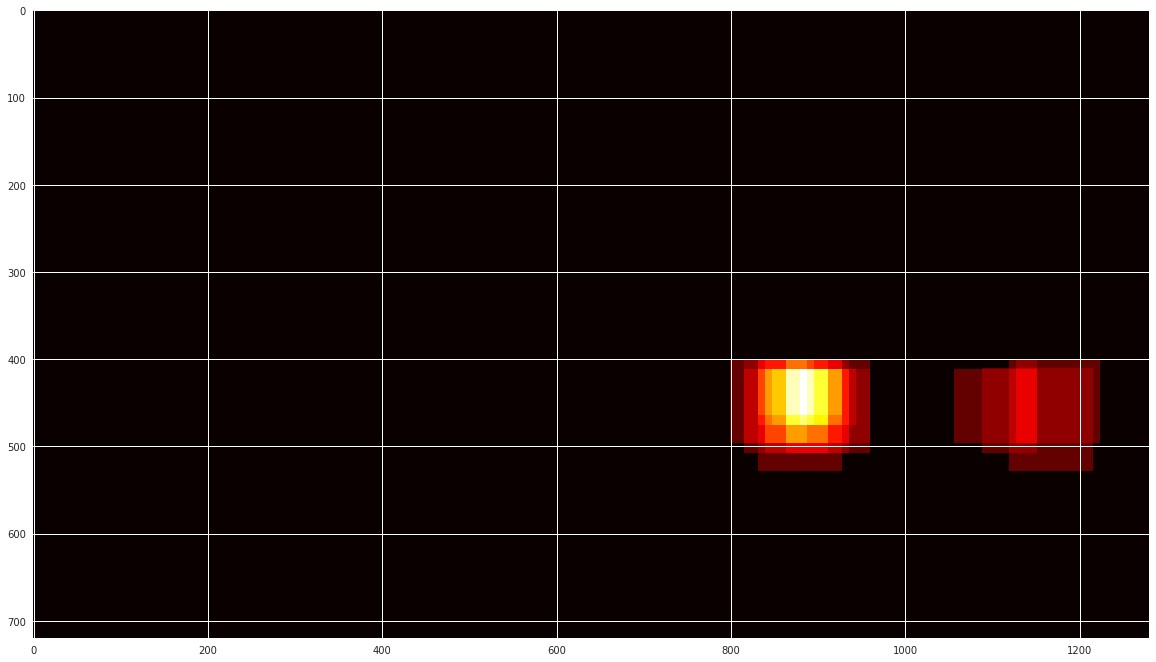

In [13]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

threshold_heatmap_img = apply_threshold(heatmap_img, 1)

plt.figure(figsize=(20,20))
plt.imshow(heatmap_img, cmap='hot')

### Apply Labels

2 vehicles found


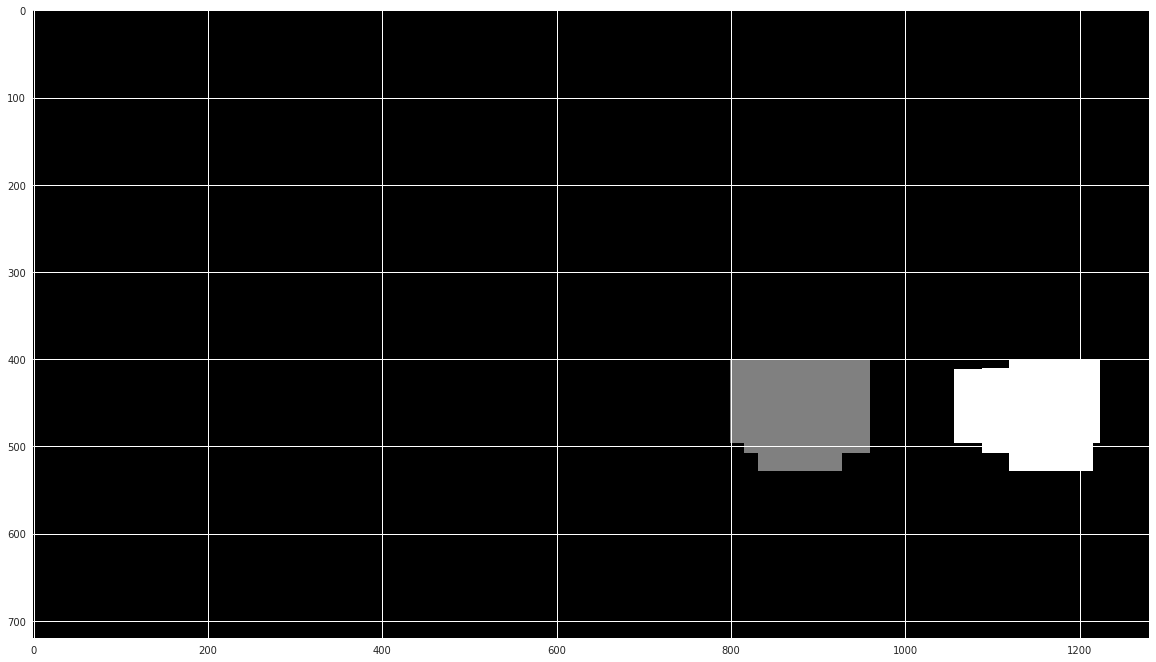

In [14]:
labels = label(threshold_heatmap_img)
print(labels[1], 'vehicles found')

plt.figure(figsize=(20,20))
plt.imshow(labels[0], cmap='gray')

### Draw bounding boxes for the labels

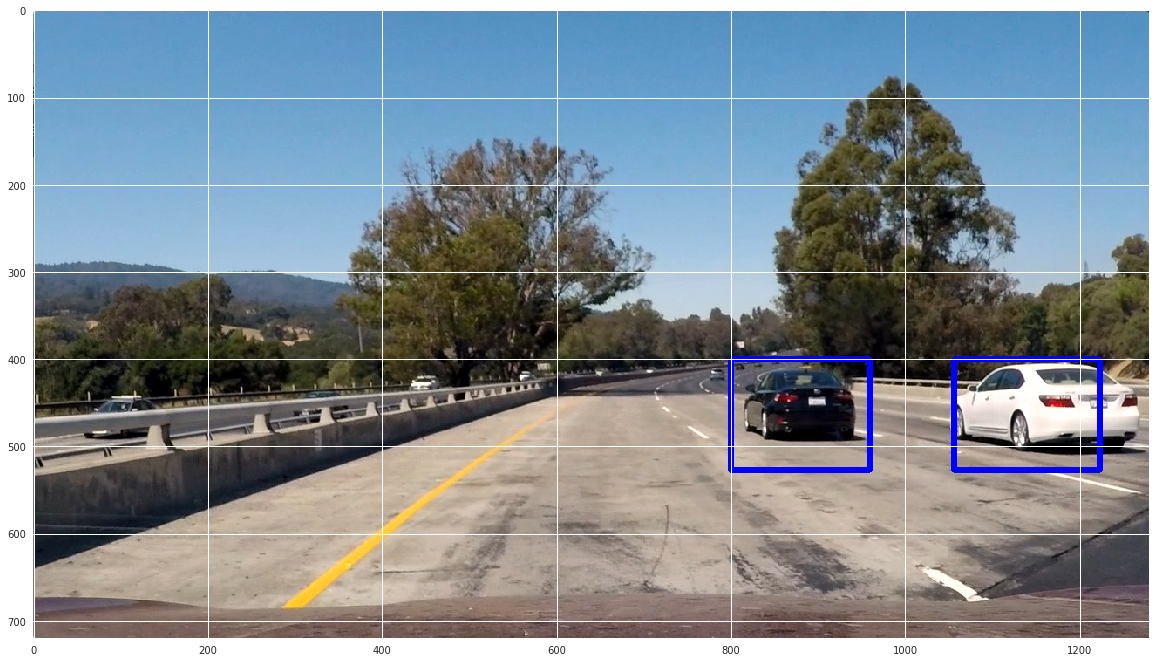

In [15]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

output_img = draw_labeled_bboxes(test_image, labels)

plt.figure(figsize=(20,20))
plt.imshow(output_img)

### Define Pipeline

In [16]:
def process_video_frame(img):
    draw_img = np.copy(img)
    
    c_space = 'YUV'
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel='ALL'
    
    rectangles = []
    
    ystart = 400
    ystop = 480
    scale = 1.0

    rectangles.append(find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

    ystart = 412
    ystop = 498
    scale = 1.0

    rectangles.append(find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

    ystart = 400
    ystop = 526
    scale = 1.5

    rectangles.append(find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

    ystart = 412
    ystop = 538
    scale = 1.5

    rectangles.append(find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

    ystart = 400
    ystop = 560
    scale = 2.0

    rectangles.append(find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

    ystart = 410
    ystop = 570
    scale = 2.0

    rectangles.append(find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

    ystart = 380
    ystop = 654
    scale = 3.0

    rectangles.append(find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

    ystart = 400
    ystop = 664
    scale = 3.0

    rectangles.append(find_cars(draw_img, ystart, ystop, scale, svc, X_scaler, color_space=c_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

    rectangles = [item for sublist in rectangles for item in sublist]
    
    heatmap_img = np.zeros_like(draw_img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    threshold_heatmap_img = apply_threshold(heatmap_img, 2)
    
    labels = label(threshold_heatmap_img)
    output_img = draw_labeled_bboxes(draw_img, labels)
    
    return output_img

### Test/Verify Pipeline

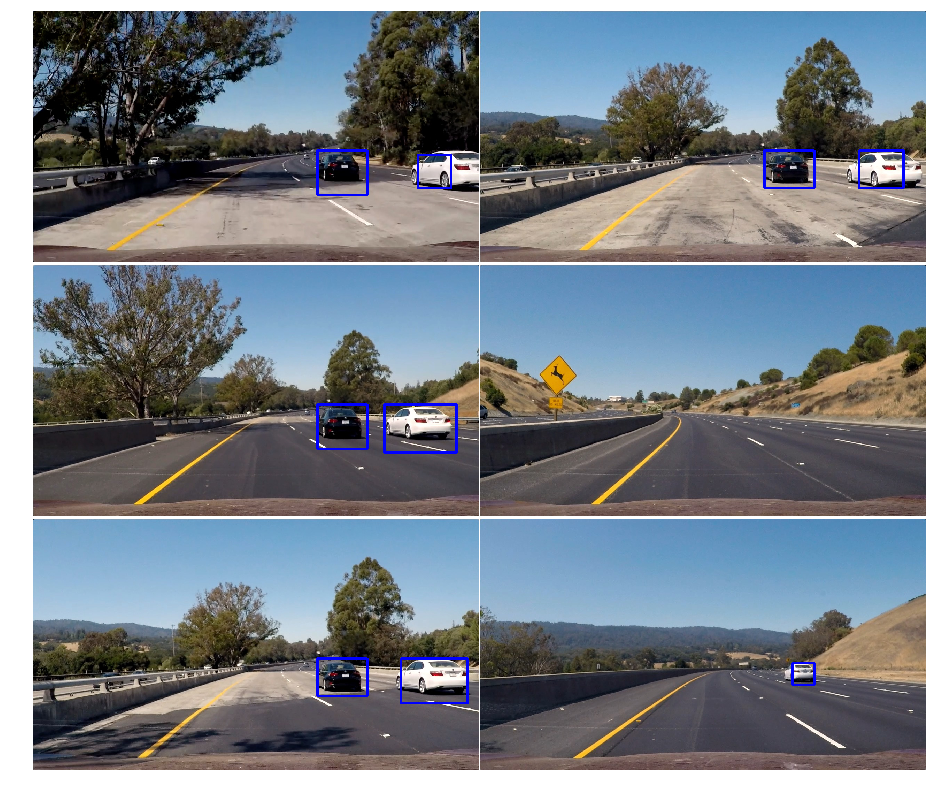

In [20]:
images = glob.glob("test_images/test*.jpg")
processed_imgs = []

for fname in images:    
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = process_video_frame(image)
    processed_imgs.append(result)

fig, axs = plt.subplots(3, 2, figsize=(16,14))
axs = axs.ravel()
fig.subplots_adjust(hspace = .004, wspace=.002)

for i, im in enumerate(processed_imgs):
    axs[i].imshow(im)
    axs[i].axis('off')

### Process Video

In [21]:
clip1 = VideoFileClip("project_video.mp4")
video_output = clip1.fl_image(process_video_frame) 

if not os.path.isfile("project_video.mp4"):
    exit
        
%time video_output.write_videofile('project_video_output.mp4', audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [27:14<00:01,  1.35s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 31min, sys: 3.93 s, total: 31min 4s
Wall time: 27min 15s
